In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/04/09 13:31:35 WARN Utils: Your hostname, Chaitanyasumas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.3.70 instead (on interface en0)
24/04/09 13:31:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/09 13:31:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Data Exploration

Source - https://archive.ics.uci.edu/dataset/320/student+performance 

In [2]:
math_df = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

In [3]:
math_df.printSchema()
math_df.show(5)

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

24/04/09 13:31:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
|    GP|  F| 17|      U|    GT3|      T|

In [4]:
# portuguese_df.printSchema()
portuguese_df.show(10)

+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|    Mjob|    Fjob|    reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4| at_home| teacher|    course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|    GP|  F| 17|    

24/04/09 13:31:55 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Defining the Benchmark

Reference - 
[1] Garrido, G. M., Near, J., Muhammad, A., He, W., Matzutt, R., & Matthes, F. (2021). Do I get the privacy I need? Benchmarking utility in differential privacy libraries. arXiv preprint arXiv:2109.10789.

[1] defines two attributes as sensitive - _absence_days_ and _final_exam_grade_. They also state that - 

"To set the range bounds for the sensitivity calculation, we selected values based on the domain knowledge of the real-world datasets’ attributes, e.g., for the age attribute, we selected a lower bound and an upper bound of 0 and a 100 years, respectively."

We follow the same setup.

Test Queries for PAC-DB and PipelineDP
1. Count, Sum, Mean, Var

## Using the Hybrid Algorithm

In [ ]:
def hybrid_noise_general(train_x, train_y, mechanism, subsample_rate, num_classes,
    eta, regularize=None, num_trees=None, tree_depth = None, max_mi = 1., proj_matrix = None):
    
    sec_v = max_mi / 2
    sec_beta = max_mi - sec_v
    r = calc_r(train_x)
    gamma = 0.01
    avg_dist = 0.
    curr_est = None
    converged = False
    curr_trial = 0

    if num_classes is None:
        num_classes = len(set(train_y))

    assert subsample_rate >= num_classes

    est_y = {}
    prev_ests = None
    # 10*c*v
    seed = np.random.randint(1, 100000)

    if proj_matrix is None:
        outputs = []
        for _ in range(5000):
            shuffled_x, shuffled_y = shuffle(train_x, train_y)
            
            # get samples
            shuffled_x, shuffled_y = get_samples_safe(shuffled_x, shuffled_y, num_classes, subsample_rate)

            # apply

            outputs.append(output)
        y_cov = np.cov(np.array(outputs).T)
        
        u, eigs, u_t = np.linalg.svd(y_cov)
        proj_matrix = u


    while not converged:
        shuffled_x, shuffled_y = shuffle(train_x, train_y)
        
        
        shuffled_x, shuffled_y = get_samples_safe(shuffled_x, shuffled_y, num_classes, subsample_rate)

        if mechanism == run_kmeans:
            output = mechanism(shuffled_x, shuffled_y, num_classes, seed)[1]

        if mechanism == run_svm:
            output = mechanism(shuffled_x, shuffled_y, num_classes, seed, regularize)[1]

        if mechanism.__name__ == 'fit_forest' or mechanism.__name__ == 'fit_gbdt':
            assert num_trees is not None
            assert tree_depth is not None
            output = mechanism(shuffled_x, shuffled_y, num_trees, tree_depth, seed, regularize)[1]

    
        for ind in range(len(output)):
            if ind not in est_y:
                est_y[ind] = []
            est_y[ind].append(np.matmul(proj_matrix[ind].T, np.array(output).T))

        if curr_trial % 10 == 0:        
            if prev_ests is None:
                prev_ests = {}
                for ind in est_y:
                    prev_ests[ind] = np.var(est_y[ind])
            else:
                converged = True
                for ind in est_y:
                    if abs(np.var(est_y[ind]) - prev_ests[ind]) > eta:
                        converged = False
                if not converged:
                    for ind in est_y:
                        prev_ests[ind] = np.var(est_y[ind])
        curr_trial += 1
    fin_var = {ind: np.var(est_y[ind]) for ind in est_y}

    noise = {}
    sqrt_total_var = sum(fin_var.values())**0.5
    print(f'sqrt total var is {sqrt_total_var}')
    for ind in fin_var:
        noise[ind] = 1./max_mi**0.5 * fin_var[ind]**0.5 * sqrt_total_var

    return proj_matrix, noise


## Max + Avg

In [5]:
# Non-private query
from pyspark.sql.functions import max as pyspark_max, mean as pyspark_mean

mean_result = math_df.filter(math_df["Mjob"] == "at_home").agg(pyspark_mean('absences').alias('mean_value')).collect()[0]['mean_value']
max_result = math_df.filter(math_df["Mjob"] == "at_home").agg(pyspark_max('absences').alias('max_value')).collect()[0]['max_value']

print(max_result, mean_result)

28 4.694915254237288


In [16]:
# Private Query - 
# 1. find variance separately, add noise separately
# 2. find variance of a vector of results, add noise

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment

user_defined_sampling_rate = 0.5
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get 3 results - max, mean and (max, mean)
    y_max = []
    y_mean = []
    y_max_and_mean = []
    for _ in range(m): 
        # filter first
        pac_defaulters_df = create_pac_df(math_df.filter(math_df["Mjob"] == "at_home"), user_defined_sampling_rate, seed=None)
    
        # sample filtered data, and find all 3 results
        y_i_mean = (pac_defaulters_df.sample()
            .agg(pyspark_mean('absences').alias('mean_value')).collect()[0]['mean_value'])
        y_i_max = (pac_defaulters_df.sample()
            .agg(pyspark_max('absences').alias('max_value')).collect()[0]['max_value'])
        y_i_max_mean = [[y_i_max], [y_i_mean]]

        y_max.append(y_i_max)
        y_mean.append(y_i_mean)
        y_max_and_mean.append(y_i_max_mean)
        
    avg_max = np.cov(y_max)
    avg_mean = np.cov(y_mean)
    
    avg_mean_max = 0
    for y_1 in y_max_and_mean:
        for y_2 in y_max_and_mean:
            C = distance.cdist(y_1, y_2)
            assignment = linear_sum_assignment(C)
            arr = np.dstack(assignment)[0]
            arr = arr[arr[:, 0].argsort()]
            sorted_ids = arr[:, 1]
            y_2 = np.array([y_2[sorted_ids[j]] for j in range(len(sorted_ids))])

            dist = 0.
            for ind in range(2):
                dist += np.linalg.norm(np.array(y_1[ind]) - np.array(y_2[ind]))**2 / 2
            avg_mean_max += dist
    avg_mean_max /= m**2

    return avg_max, avg_mean, avg_mean_max

avg_max, avg_mean, avg_mean_max = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_max, avg_mean, avg_mean_max)


21.794285714285717 0.6299517645511922 21.97575272926019


In [17]:
true_mean = 4.7
true_max = 28
true_max_mean = [true_max, true_mean]
sampled_mean_error = []
sampled_max_error = []
sampled_mean_max_error = []
private_mean_error = []
private_max_error = []
private_mean_max_error = []
for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 
    # and variance as avg_min_distance
    noise_only_max = paclib.mechanism.noise_to_add(avg_max, c, budget)
    noise_only_mean = paclib.mechanism.noise_to_add(avg_mean, c, budget)
    noise_mean_max_isotropic = paclib.mechanism.noise_to_add(avg_mean_max, c, budget)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df.filter(math_df["Mjob"] == "at_home"), 
                                      user_defined_sampling_rate, 
                                      seed=None)
    y_i_mean = (pac_defaulters_df.sample()
            .agg(pyspark_mean('absences').alias('mean_value')).collect()[0]['mean_value'])
    y_i_max = (pac_defaulters_df.sample()
            .agg(pyspark_max('absences').alias('max_value')).collect()[0]['max_value'])
    y_i_max_mean = [y_i_max, y_i_mean]

    sampled_mean_error.append(np.mean((y_i_mean - true_mean) ** 2))
    sampled_max_error.append(np.mean((y_i_max - true_max) ** 2))
    sampled_mean_max_error.append(np.mean((np.array(y_i_max_mean) - np.array(true_max_mean))**2))

    priv_y_mean = y_i_mean + noise_only_mean
    priv_y_max = y_i_max + noise_only_max
    for ind in range(len(y_i_max_mean)):
        y_i_max_mean[ind] += noise_mean_max_isotropic

    private_mean_error.append(np.mean((priv_y_mean - true_mean) ** 2))
    private_max_error.append(np.mean((priv_y_max - true_max) ** 2))
    private_mean_max_error.append(np.mean((np.array(true_max_mean) - np.array(y_i_max_mean))**2))

# plt.xscale('log', base=2)
# plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

# plt.xlabel('Mutual Information (Log Scale)')
# plt.ylabel('Error')
# plt.title('Subsampled vs. Private Error')
# plt.legend()

# plt.grid(True)

# folder_path = 'figs/student_performance'
# plt.savefig(folder_path + '/count_error.png')

# plt.show()



In [19]:
# import math

# import matplotlib.pyplot as plt
# import mplcursors

# plt.plot

# plt.xscale('log', base=2)
# plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

# plt.xlabel('Mutual Information (Log Scale)')
# plt.ylabel('Error')
# plt.title('Subsampled vs. Private Error')
# plt.legend()

# plt.grid(True)

# folder_path = 'figs/student_performance'
# plt.savefig(folder_path + '/count_error.png')

# plt.show()

In [20]:
budget_list[3:]

[0.125, 0.25, 0.5, 1.0, 2.0, 4.0]

In [21]:
print(sampled_mean_error)
print(private_mean_error)
print(sampled_max_error)
print(private_max_error)
print(sampled_mean_max_error)
print(private_mean_max_error)

[0.029100346020761343, 1.0476124567474057, 0.1361355529131982, 1.548641975308642, 0.031965105601469215, 0.00033057851239670654, 0.5841326530612244, 1.2939062500000005, 0.03408284023668648]
[3922.7545898030203, 573.9857989454305, 19.068990847592012, 68.29181729402725, 10.107196875800588, 0.009012513701356936, 1.9999231506801467, 1.4833033601239323, 0.06664910786445732]
[256.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0]
[364570.8882271328, 755498.2793284056, 71382.18125538481, 169.89838134530862, 175.07282394457266, 1477.0793118142637, 134.73214825176416, 240.885823281206, 256.62850307885594]
[128.01455017301038, 0.5238062283737028, 0.0680677764565991, 0.774320987654321, 0.015982552800734608, 0.00016528925619835327, 0.2920663265306122, 0.6469531250000002, 50.017041420118346]
[4589462.673204408, 384407.88549526624, 330234.7631242288, 16670.63354432724, 216.82729084595917, 2026.0128732396079, 361.2419075742747, 0.38596265014341574, 133.00438309512336]


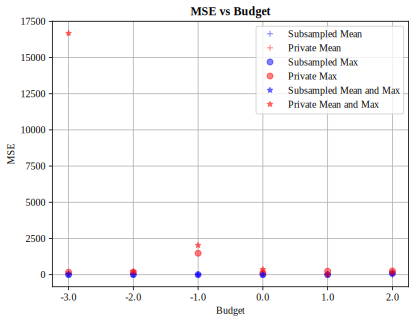

24/03/21 15:40:02 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 143008 ms exceeds timeout 120000 ms
24/03/21 15:40:02 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/21 15:40:09 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [22]:
# Accuracy Plot
import math

import matplotlib.pyplot as plt
import mplcursors

fig, ax = plt.subplots()
ax.grid(True)

ax.plot(budget_list[3:], sampled_mean_error[3:], 'b+', label='Subsampled Mean', alpha=0.5)  
ax.plot(budget_list[3:], private_mean_error[3:], 'r+', label='Private Mean', alpha=0.5)
ax.plot(budget_list[3:], sampled_max_error[3:], 'bo', label='Subsampled Max', alpha=0.5) 
ax.plot(budget_list[3:], private_max_error[3:], 'ro', label='Private Max', alpha=0.5) 
ax.plot(budget_list[3:], sampled_mean_max_error[3:], 'b*', label='Subsampled Mean and Max', alpha=0.5)  
ax.plot(budget_list[3:], private_mean_max_error[3:], 'r*', label='Private Mean and Max', alpha=0.5) 

plt.xscale('log', base=2)
plt.xticks(budget_list[3:], [format(np.log2(val)) for val in budget_list[3:]])

# Add labels and legend
ax.set_xlabel('Budget')
ax.set_ylabel('MSE')
ax.set_title('MSE vs Budget')
ax.legend()

## Count

In [5]:
# Non-private query

defaulters = math_df.filter(math_df["absences"] >= 5) # More than 5 absent days
defaulters.count()

151

24/03/14 13:40:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [19]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    y_1 = []
    y_2 = []
    for _ in range(m): 
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(df["absences"] >= 5)
            .count())
        y_i_2 = (pac_defaulters_df.sample()
        .filter(df["absences"] >= 5)
        .count())

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        min_distances.append(current_distance)

        # all pairwise difference
    y_1.extend(y_2)
    new_distances = []
    for i in range(len(y_1)):
        for j in range(i + 1, len(y_1)):
            distance = np.linalg.norm(y_1[i] - y_1[j])
            new_distances.append(distance)

    # Calculate the average minimum perturbation distance
    avg_min_perturbation_distance = np.mean(new_distances)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance, avg_min_perturbation_distance

avg_min_distance, avg_min_perturbation_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance, avg_min_perturbation_distance)


13.92 13.772121212121212


In [20]:
final_results = []
subsampled_error = []
private_count_error = []
private_count_error_trial = []

defaulters = 151

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 
    # and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    noise_all_pairwise = paclib.mechanism.noise_to_add(avg_min_perturbation_distance, c, budget)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    y_final = (pac_defaulters_df.sample()
                .filter(math_df["absences"] >= 5)
                .count())
    
    y_final *= (1/user_defined_sampling_rate)
    
    error_of_subsampled_defaulters = abs(defaulters - y_final)/defaulters
    subsampled_error.append(error_of_subsampled_defaulters)

    y_trial = y_final + abs(noise_all_pairwise)
    y_final += abs(noise)
    
    priv_defaulters = abs(defaulters - y_final)/defaulters
    priv_defaulters_trial = abs(defaulters - y_trial)/defaulters

    private_count_error.append(priv_defaulters)
    private_count_error_trial.append(priv_defaulters_trial)

    final_results.append(y_final)

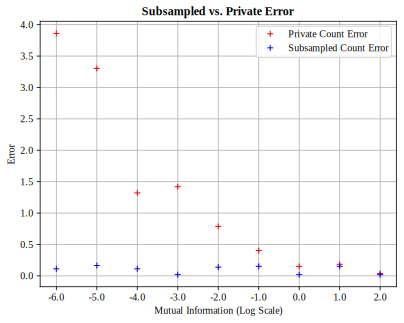

In [21]:
# Accuracy Plot
import math

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_count_error, 'r+', label='Private Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Subsampled Count Error')
# plt.plot(budget_list, private_count_error_trial, 'g+', label='Private Count Error (All pairwise differences)')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
plt.title('Subsampled vs. Private Error')
plt.legend()

plt.grid(True)

folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/count_error.png')

plt.show()



In [79]:
# # Step 3: Calculate Noise

# from pacdb import QueryRewriter, Aggregator
# trials = 200

# # filter = pac_defaulters_df.add_filter("math_df[\"absences\"] >= 5")
# # aggr = pac_defaulters_df.map_to_function("count")

# # samples = pac_defaulters_df.get_samples(pac_defaulters_df, user_defined_sampling_rate, filter, aggr, trials)
# sampled_counts = samples
# pairwise_differences = []

# for i in range(len(sampled_counts)):
#     for j in range(i + 1, len(sampled_counts)):
#         difference = sampled_counts[i] - sampled_counts[j]
#         pairwise_differences.append(difference)

In [81]:
# visualize change from the strict pairwise sampling to all pairwise sampling

## Sum

In [22]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

sum_result = math_df.filter(math_df["Mjob"] == "at_home").agg(spark_sum("studytime")).collect()
sum_of_x = sum_result[0]["sum(studytime)"]

print(sum_of_x)

124


In [23]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(df["Mjob"] == "at_home")
            .agg(spark_sum("studytime"))).collect()
        y_i_2 = (pac_defaulters_df.sample()
                .filter(df["Mjob"] == "at_home")
                .agg(spark_sum("studytime"))).collect()

        y_i_1 = y_i_1[0]["sum(studytime)"]
        y_i_2 = y_i_2[0]["sum(studytime)"]

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  120.0 124.0
Current distance  4.0
trial  1
For current trial  1  the values are  142.0 144.0
Current distance  2.0
trial  2
For current trial  2  the values are  124.0 108.0
Current distance  16.0
trial  3
For current trial  3  the values are  102.0 104.0
Current distance  2.0
trial  4
For current trial  4  the values are  128.0 118.0
Current distance  10.0
trial  5
For current trial  5  the values are  122.0 142.0
Current distance  20.0
trial  6
For current trial  6  the values are  120.0 96.0
Current distance  24.0
trial  7
For current trial  7  the values are  124.0 142.0
Current distance  18.0
trial  8
For current trial  8  the values are  106.0 106.0
Current distance  0.0
trial  9
For current trial  9  the values are  140.0 150.0
Current distance  10.0
trial  10
For current trial  10  the values are  138.0 128.0
Current distance  10.0
trial  11
For current trial  11  the values are  110.0 166.0
Current distance  56.0
trial  12
For cur

In [24]:
final_results = []
subsampled_error = []

actual_result = 124

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter(math_df["Mjob"] == "at_home")
                .agg(spark_sum("studytime"))).collect()

    y_final = y_final[0]["sum(studytime)"]
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -615.9004665242984
subsampled count is  150.0
private count is  765.9004665242984
For current MI value, 0.03125
Noise computed to be -  563.742853430785
subsampled count is  110.0
private count is  673.742853430785
For current MI value, 0.0625
Noise computed to be -  -339.92399709891566
subsampled count is  84.0
private count is  423.92399709891566
For current MI value, 0.125
Noise computed to be -  303.4748577879324
subsampled count is  108.0
private count is  411.4748577879324
For current MI value, 0.25
Noise computed to be -  49.01563856771556
subsampled count is  116.0
private count is  165.01563856771557
For current MI value, 0.5
Noise computed to be -  -38.92939635945113
subsampled count is  106.0
private count is  144.92939635945112
For current MI value, 1.0
Noise computed to be -  23.654873970040487
subsampled count is  122.0
private count is  145.65487397004048
For current MI value, 2.0
Noise computed to be -  -0.316329253

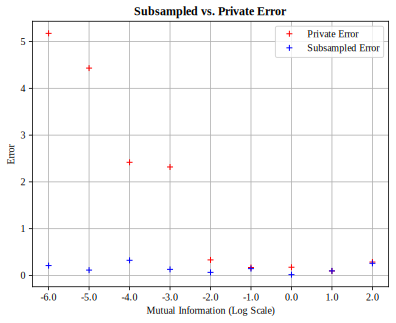

In [25]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Private Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Subsampled Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/sum_error.png')
plt.title('Subsampled vs. Private Error')
plt.legend()

plt.grid(True)
plt.show()



## Singular result

In [26]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

singular_result_set = math_df.filter((math_df["absences"] > 20) & (math_df["Mjob"] == "at_home")).count()

print(singular_result_set)

1


In [27]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 20) & (df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 20) & (df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  0.0 0.0
Current distance  0.0
trial  1
For current trial  1  the values are  0.0 2.0
Current distance  2.0
trial  2
For current trial  2  the values are  2.0 0.0
Current distance  2.0
trial  3
For current trial  3  the values are  0.0 2.0
Current distance  2.0
trial  4
For current trial  4  the values are  2.0 0.0
Current distance  2.0
trial  5
For current trial  5  the values are  0.0 2.0
Current distance  2.0
trial  6
For current trial  6  the values are  2.0 2.0
Current distance  0.0
trial  7
For current trial  7  the values are  0.0 0.0
Current distance  0.0
trial  8
For current trial  8  the values are  0.0 2.0
Current distance  2.0
trial  9
For current trial  9  the values are  2.0 0.0
Current distance  2.0
trial  10
For current trial  10  the values are  2.0 0.0
Current distance  2.0
trial  11
For current trial  11  the values are  0.0 2.0
Current distance  2.0
trial  12
For current trial  12  the values are  0.0 0.0
Current distanc

In [28]:
final_results = []
subsampled_error = []

actual_result = 1

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["absences"] > 20) & (math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  17.2325899464104
subsampled count is  2.0
private count is  19.2325899464104
For current MI value, 0.03125
Noise computed to be -  75.9886753112413
subsampled count is  0.0
private count is  75.9886753112413
For current MI value, 0.0625
Noise computed to be -  6.9780747282876
subsampled count is  0.0
private count is  6.9780747282876
For current MI value, 0.125
Noise computed to be -  -16.038684756594595
subsampled count is  0.0
private count is  16.038684756594595
For current MI value, 0.25
Noise computed to be -  -0.18312561106036965
subsampled count is  2.0
private count is  2.18312561106037
For current MI value, 0.5
Noise computed to be -  -1.8411581596322715
subsampled count is  0.0
private count is  1.8411581596322715
For current MI value, 1.0
Noise computed to be -  1.111613929485773
subsampled count is  2.0
private count is  3.111613929485773
For current MI value, 2.0
Noise computed to be -  0.04486974844863256
subsampled c

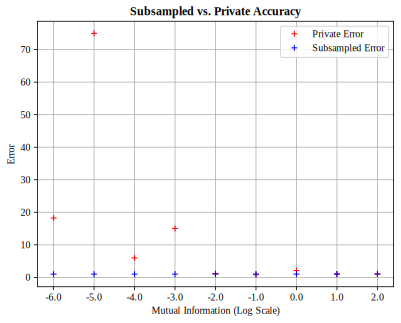

In [29]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Private Error')  
plt.plot(budget_list, subsampled_error, 'b+', label="Subsampled Error")

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')

plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)

folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/singular_count_error.png')
plt.show()

# Question: Is this a violation of PAC? IMO, reconstruction hardness still holds


## Max

In [34]:
max_result = math_df.agg({"absences": "max"}).collect()[0][0]
print(max_result)

75


In [35]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .agg({"absences": "max"})).collect()[0][0]
        y_i_2 = (pac_defaulters_df.sample()
            .agg({"absences": "max"})).collect()[0][0]

        # y_i_1 *= (1/user_defined_sampling_rate)
        # y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  75 38
Current distance  37.0
trial  1
For current trial  1  the values are  75 56
Current distance  19.0
trial  2
For current trial  2  the values are  28 75
Current distance  47.0
trial  3
For current trial  3  the values are  75 75
Current distance  0.0
trial  4
For current trial  4  the values are  75 56
Current distance  19.0
trial  5
For current trial  5  the values are  75 75
Current distance  0.0
trial  6
For current trial  6  the values are  56 56
Current distance  0.0
trial  7
For current trial  7  the values are  75 75
Current distance  0.0
trial  8
For current trial  8  the values are  75 75
Current distance  0.0
trial  9
For current trial  9  the values are  75 75
Current distance  0.0
trial  10
For current trial  10  the values are  75 56
Current distance  19.0
trial  11
For current trial  11  the values are  56 56
Current distance  0.0
trial  12
For current trial  12  the values are  75 75
Current distance  0.0
trial  13
For 

In [36]:
final_results = []
subsampled_error = []

actual_result = 75

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .agg({"absences": "max"})).collect()[0][0]

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  424.5359844770885
subsampled count is  56
private count is  480.5359844770885
For current MI value, 0.03125
Noise computed to be -  617.886646228107
subsampled count is  75
private count is  692.886646228107
For current MI value, 0.0625
Noise computed to be -  -3.253261693062908
subsampled count is  56
private count is  59.25326169306291
For current MI value, 0.125
Noise computed to be -  -193.81513761316634
subsampled count is  75
private count is  268.81513761316637
For current MI value, 0.25
Noise computed to be -  -31.999504320002274
subsampled count is  54
private count is  85.99950432000227
For current MI value, 0.5
Noise computed to be -  -21.688576034962313
subsampled count is  56
private count is  77.68857603496231
For current MI value, 1.0
Noise computed to be -  -0.521426457466857
subsampled count is  75
private count is  75.52142645746686
For current MI value, 2.0
Noise computed to be -  2.560010332994745
subsampled cou

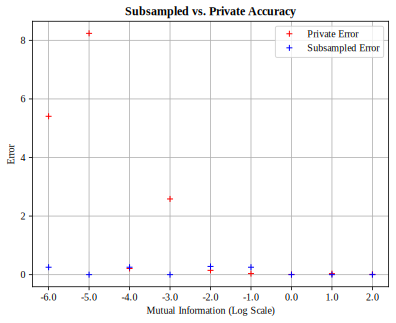

In [37]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Private Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Subsampled Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')

plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)

folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/max_error.png')

plt.show()

# Observation - the subsampled accuracy itself falls, but PAC holds...


## Aggregate Stats in case of skewed distribution

In [38]:
# Assuming 'df' is your DataFrame and 'column_name' is the name of the column containing "yes" and "no"
counts_df = math_df.groupBy("guardian").agg(count("*").alias("count"))

# Display the counts
counts_df.show()


+--------+-----+
|guardian|count|
+--------+-----+
|  father|   90|
|  mother|  273|
|   other|   32|
+--------+-----+



In [40]:
actual_result = math_df.filter(col("guardian") == "father").count()
print(actual_result)

90


In [41]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()
        y_i_2 = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


12.28


In [42]:
final_results = []
subsampled_error = []
private_error = []

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    priv_result = abs(actual_result - y_final)/actual_result
    private_error.append(priv_result)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  702.2115133795241
subsampled count is  82.0
private count is  784.2115133795241
For current MI value, 0.03125
Noise computed to be -  -475.94852061260974
subsampled count is  106.0
private count is  581.9485206126097
For current MI value, 0.0625
Noise computed to be -  99.17960384363109
subsampled count is  98.0
private count is  197.17960384363107
For current MI value, 0.125
Noise computed to be -  113.95451271723334
subsampled count is  78.0
private count is  191.95451271723334
For current MI value, 0.25
Noise computed to be -  45.80132260354116
subsampled count is  96.0
private count is  141.80132260354117
For current MI value, 0.5
Noise computed to be -  3.360330124376534
subsampled count is  82.0
private count is  85.36033012437653
For current MI value, 1.0
Noise computed to be -  15.873205562138915
subsampled count is  102.0
private count is  117.87320556213892
For current MI value, 2.0
Noise computed to be -  -2.417898618735

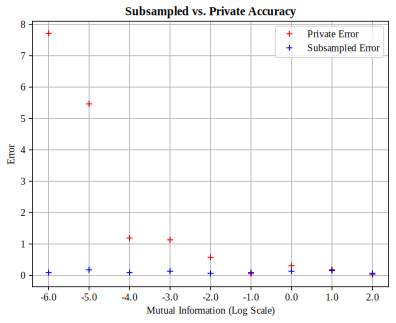

In [43]:
# Accuracy Plot

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Private Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Subsampled Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')

plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)

folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/skewed_count_error.png')
plt.show()

# Observation - the subsampled accuracy itself falls, but PAC holds...


## Multiple Predicates - Apply first

In [60]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

empty_result_set = math_df.filter((math_df["absences"] > 10) & (math_df["Mjob"] == "at_home")).count()

print(empty_result_set)

8


In [ ]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

one_result = math_df.filter((math_df["absences"] == 9) & (math_df["Mjob"] == "at_home")).count()

print(empty_result_set)

In [61]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
# tau = 3
# seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 10) & (df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
                .filter((df["absences"] > 10) & (df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  2.0 6.0
Current distance  4.0
trial  1
For current trial  1  the values are  4.0 12.0
Current distance  8.0
trial  2
For current trial  2  the values are  8.0 8.0
Current distance  0.0
trial  3
For current trial  3  the values are  4.0 12.0
Current distance  8.0
trial  4
For current trial  4  the values are  8.0 6.0
Current distance  2.0
trial  5
For current trial  5  the values are  4.0 10.0
Current distance  6.0
trial  6
For current trial  6  the values are  6.0 12.0
Current distance  6.0
trial  7
For current trial  7  the values are  8.0 8.0
Current distance  0.0
trial  8
For current trial  8  the values are  6.0 6.0
Current distance  0.0
trial  9
For current trial  9  the values are  8.0 10.0
Current distance  2.0
trial  10
For current trial  10  the values are  6.0 4.0
Current distance  2.0
trial  11
For current trial  11  the values are  8.0 6.0
Current distance  2.0
trial  12
For current trial  12  the values are  10.0 4.0
Current d

In [62]:
final_results = []
subsampled_error = []

actual_result = 8

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["absences"] > 10) & (math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -499.26163317059144
subsampled count is  12.0
private count is  511.26163317059144
For current MI value, 0.03125
Noise computed to be -  77.76389305189274
subsampled count is  16.0
private count is  93.76389305189274
For current MI value, 0.0625
Noise computed to be -  -46.467009914207395
subsampled count is  8.0
private count is  54.467009914207395
For current MI value, 0.125
Noise computed to be -  -54.6575240994656
subsampled count is  4.0
private count is  58.6575240994656
For current MI value, 0.25
Noise computed to be -  0.6190020987824699
subsampled count is  2.0
private count is  2.61900209878247
For current MI value, 0.5
Noise computed to be -  -2.0223710095893153
subsampled count is  12.0
private count is  14.022371009589316
For current MI value, 1.0
Noise computed to be -  0.8054903996259809
subsampled count is  8.0
private count is  8.805490399625981
For current MI value, 2.0
Noise computed to be -  1.150773175487027
su

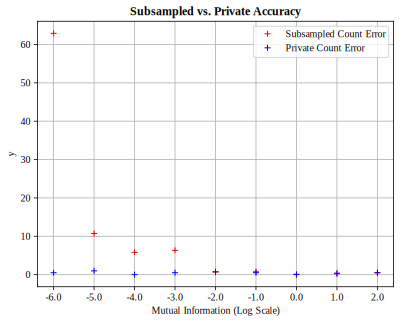

In [63]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('y')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()

## Multiple Predicates - Apply 1 filter, sample, then apply next filter

In [64]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
# tau = 3
# seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi
        y_i_1 = (pac_defaulters_df.sample()
                .filter((df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
                .filter((df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df.filter(math_df["absences"] > 10), user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  8.0 6.0
Current distance  2.0
trial  1
For current trial  1  the values are  6.0 10.0
Current distance  4.0
trial  2
For current trial  2  the values are  8.0 12.0
Current distance  4.0
trial  3
For current trial  3  the values are  6.0 10.0
Current distance  4.0
trial  4
For current trial  4  the values are  6.0 6.0
Current distance  0.0
trial  5
For current trial  5  the values are  8.0 14.0
Current distance  6.0
trial  6
For current trial  6  the values are  2.0 6.0
Current distance  4.0
trial  7
For current trial  7  the values are  10.0 2.0
Current distance  8.0
trial  8
For current trial  8  the values are  10.0 4.0
Current distance  6.0
trial  9
For current trial  9  the values are  6.0 12.0
Current distance  6.0
trial  10
For current trial  10  the values are  12.0 10.0
Current distance  2.0
trial  11
For current trial  11  the values are  10.0 8.0
Current distance  2.0
trial  12
For current trial  12  the values are  4.0 8.0
Curre

In [65]:
final_results = []
subsampled_error = []

actual_result = 8
math_df_filtered = math_df.filter(math_df["absences"] > 10)

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df_filtered, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  286.50143422400305
subsampled count is  8.0
private count is  294.50143422400305
For current MI value, 0.03125
Noise computed to be -  2.006780587639483
subsampled count is  6.0
private count is  8.006780587639483
For current MI value, 0.0625
Noise computed to be -  12.70481367147562
subsampled count is  10.0
private count is  22.70481367147562
For current MI value, 0.125
Noise computed to be -  25.25417209136789
subsampled count is  10.0
private count is  35.25417209136789
For current MI value, 0.25
Noise computed to be -  14.110656698137102
subsampled count is  8.0
private count is  22.110656698137102
For current MI value, 0.5
Noise computed to be -  13.321717287216673
subsampled count is  8.0
private count is  21.32171728721667
For current MI value, 1.0
Noise computed to be -  -4.703820477167492
subsampled count is  4.0
private count is  8.703820477167492
For current MI value, 2.0
Noise computed to be -  -2.3320514671209707
subs

## Mean

PAC-count / PAC-sum vs PAC-mean

## Var

σ^2=n∑i=1 ​(xi​−x)^2 / n 

(Chorus does not implement variance---find out why?)​